In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize']=(20,12)
%matplotlib inline



In [40]:
WFDEI_DIR='/users/eow/edwcom/WFD_EI/'
BCfile=WFDEI_DIR+'qrparm.soil_HWSD_cont_cosbyNew.nc'
BC_2Doutfile=WFDEI_DIR+'SoilProperties_wfdei_BrookesCorey_2D.nc'
VGfile=WFDEI_DIR+'qrparm.soil_HWSD_class3_van_genuchtenNew.nc'
VG_2Doutfile=WFDEI_DIR+'SoilProperties_wfdei_VanGenuchten_2D.nc'
latlonfile=WFDEI_DIR+'EI-Halfdeg-land-elevation.nc'
grid_file=WFDEI_DIR+'wfdei-land-mask.nc'

In [41]:
BCinf=nc.Dataset(BCfile,'r')
BCdata={}
UMvars=['field1381','field342','field333','field332','field330','field329','field335','field336','field1395','field1397']
BCvars=['b','sathh','satcon','sm_sat','sm_crit','sm_wilt','hcap','hcon','albsoil','cs']
for UMvar,var in zip(UMvars,BCvars):
    BCdata[var]=BCinf.variables[str(UMvar)][:]
BCinf.close()
    

In [42]:
VGinf=nc.Dataset(VGfile,'r')
VGdata={}
UMvars=['field1381','field342','field333','field332','field330','field329','field335','field336','field1395','field1397']
VGvars=['b','sathh','satcon','sm_sat','sm_crit','sm_wilt','hcap','hcon','albsoil','cs']
for UMvar,var in zip(UMvars,VGvars):
    VGdata[var]=VGinf.variables[str(UMvar)][:]
VGinf.close()
    

In [43]:
LLinf=nc.Dataset(latlonfile,'r')
lat=LLinf.variables['latitude'][:]
lon=LLinf.variables['longitude'][:]

In [44]:
grinf=nc.Dataset(grid_file,'r')
grindex=grinf.variables['land_index'][:]-1
grlat=grinf['latitude'][:]
grlon=grinf['longitude'][:]
grinf.close()

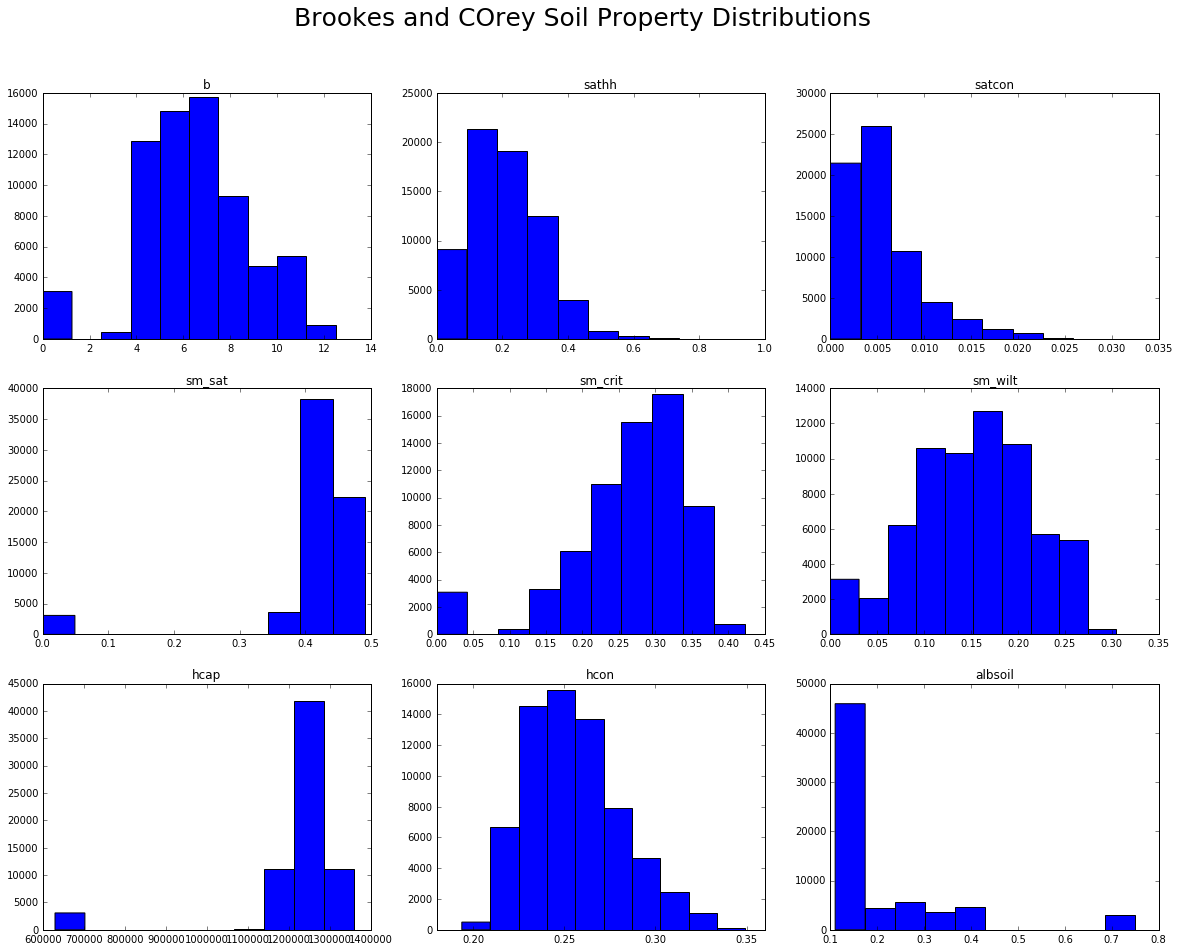

In [45]:
FIG,AXES=plt.subplots(nrows=3, ncols=3, figsize=(20,15))

for AX,var in zip(AXES.flat,BCvars):
    AX.hist(BCdata[var])
    AX.set_title(var)

FIG.suptitle('Brookes and COrey Soil Property Distributions',fontsize=25)

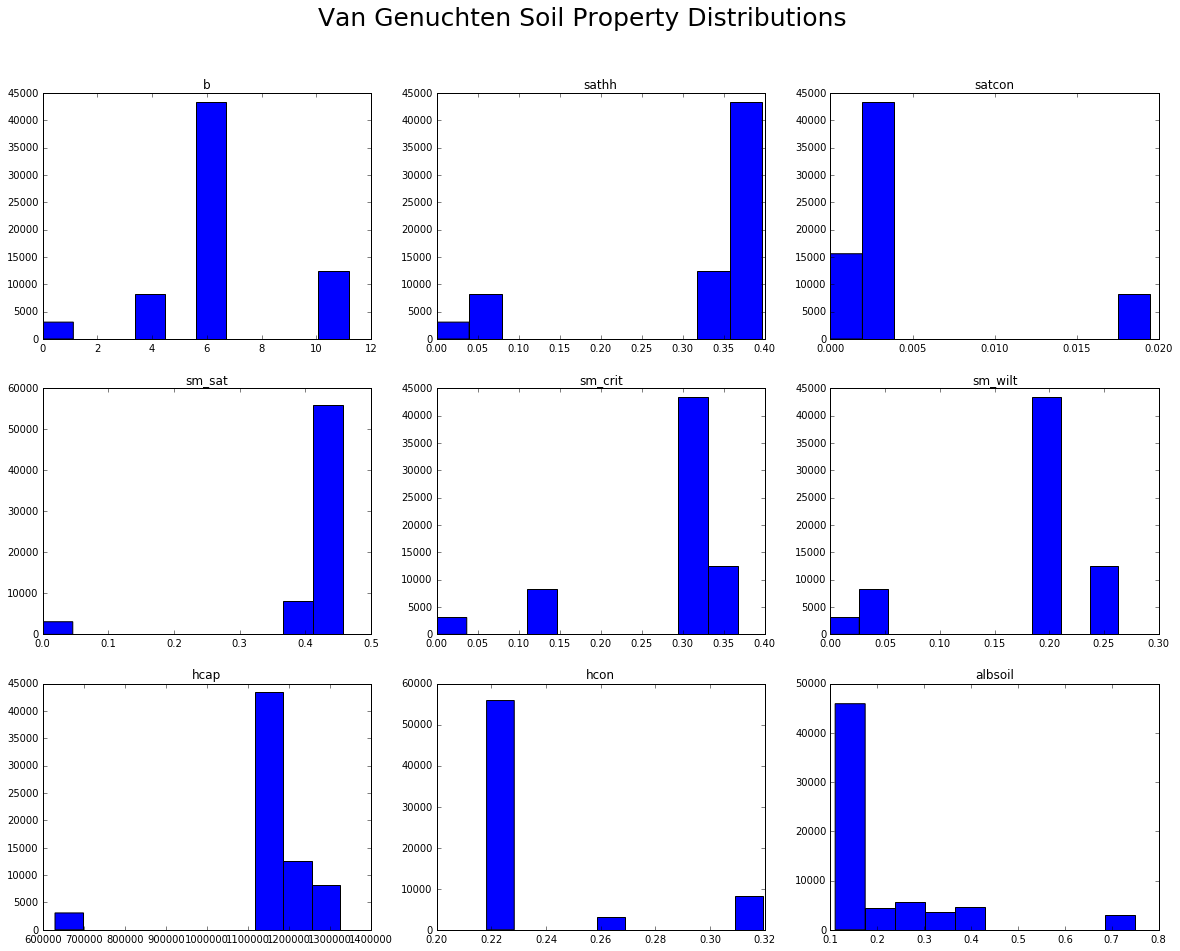

In [46]:
FIG,AXES=plt.subplots(nrows=3, ncols=3, figsize=(20,15))

for AX,var in zip(AXES.flat,VGvars):
    AX.hist(VGdata[var])
    AX.set_title(var)

FIG.suptitle('Van Genuchten Soil Property Distributions',fontsize=25)

In [47]:
site_lat,site_lon=38.9,-120.633

site_index=np.argmin( np.absolute(lat-site_lat)+np.absolute(lon-site_lon) )

print(site_index)
print(lat[site_index],lon[site_index])


3075
38.75 -120.75


In [48]:
for var,UMvar in zip(VGvars,UMvars):
    print(UMvar, var, VGdata[var][site_index])

field1381 b 6.6313
field342 sathh 0.396731
field333 satcon 0.002773
field332 sm_sat 0.4581
field330 sm_crit 0.328321
field329 sm_wilt 0.186614
field335 hcap 1.18579e+06
field336 hcon 0.22692
field1395 albsoil 0.155
field1397 cs 8.3


In [49]:
for var,UMvar in zip(BCvars,UMvars):
    print(UMvar, var, BCdata[var][site_index])

field1381 b 6.99003
field342 sathh 0.242073
field333 satcon 0.00384733
field332 sm_sat 0.439364
field330 sm_crit 0.301522
field329 sm_wilt 0.174658
field335 hcap 1.23019e+06
field336 hcon 0.243851
field1395 albsoil 0.155
field1397 cs 8.3


In [50]:
# Convert data to 2D
fill_value=-999.
VGdata2D={}
for var in VGvars:
    data2D=np.ma.masked_array(VGdata[var][grindex],mask=grindex.mask,fill_value=fill_value)
    data2D.data[data2D.mask==True]=fill_value
    VGdata2D[var]=data2D

    
BCdata2D={}
for var in BCvars:
    data2D=np.ma.masked_array(BCdata[var][grindex],mask=grindex.mask,fill_value=fill_value)
    data2D.data[data2D.mask==True]=fill_value
    BCdata2D[var]=data2D
    

In [58]:
outf.close()

In [60]:
# Write out 2D soil data

out_filenames = [BC_2Doutfile,VG_2Doutfile]
for data_dict,outfname in zip([BCdata2D,VGdata2D],out_filenames):
    outf=nc.Dataset(outfname,'w')
    # create lat/lon dimensions
    outf.createDimension('lat',len(grlat))
    outf.createDimension('lon',len(grlon))
    
    outvar=outf.createVariable('lat','float32',('lat'))
    outvar[:]=grlat
    outvar=outf.createVariable('lon','float32',('lon'))
    outvar[:]=grlon
    
    for var in data_dict:
        outvar=outf.createVariable(var,'float32',('lat','lon'),fill_value=fill_value)
        outvar[:]=data_dict[var]
    
    outf.Title=outfname
    outf.owner='Edward Comyn-Platt'
    outf.close()
    

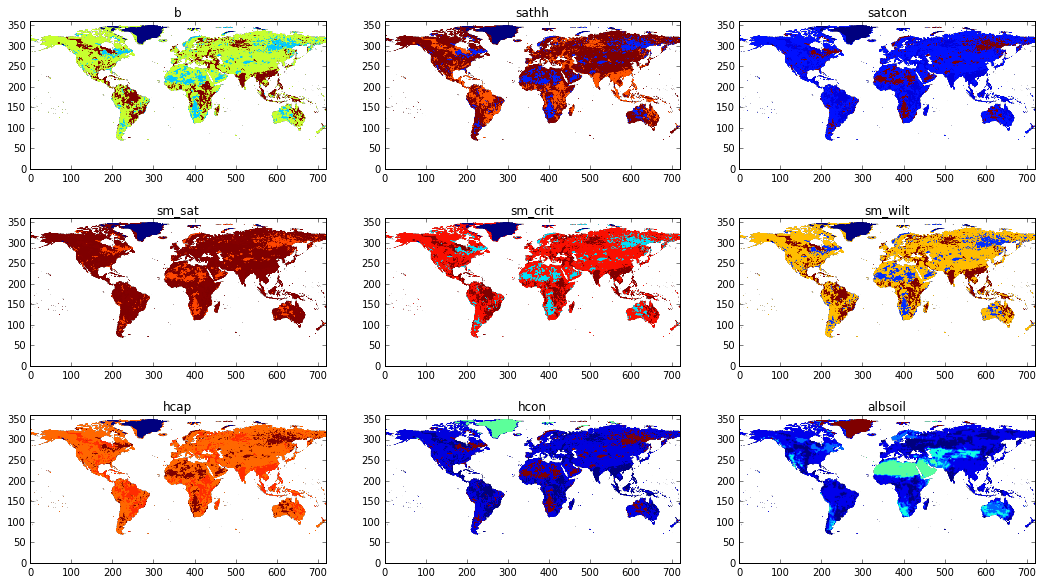

In [27]:
FIG,AXES=plt.subplots(nrows=3,ncols=3,figsize=(18,10))
for var,ax in zip(VGvars,AXES.flat):
    ax.imshow(VGdata2D[var],origin='bottom')
    ax.set_title(var)
